In [390]:
import pandas as pd
import numpy as np
import scipy as sp
import requests
import json
import folium
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="orlando")
#!pip3 install requests

# Getting the covid-19 data for Orange County
We begin by reading in the json file and converting it into a pandas dataframe.  The following json file is a geojson file.  We will use this for both determining the number of cases of covid-19 and for finding boundaries of zipcodes.

In [391]:
data = requests.get("https://opendata.arcgis.com/datasets/09ec2e757f91411b8e12445805cf2809_0.geojson?where=COUNTYNAME%20%3D%20'Orange'")
data = data.json()

**We want to see what keys we have and we determine that we need 'features'.  **

In [392]:
with open('data.json', 'w')as outfile:
    json.dump(data, outfile)

In [393]:
print (data.keys())
print(type(data['features']))

dict_keys(['type', 'name', 'crs', 'features'])
<class 'list'>


**We see that we get  a list of dicts so we will have have to wrangle our data in order to get it into a data frame.**

In [394]:
type(data['features'][0]['properties'])
data['features'][0]['geometry']


{'type': 'MultiPolygon',
 'coordinates': [[[[-81.58507389999994, 28.708257],
    [-81.58504169999998, 28.70797710000005],
    [-81.58363889999998, 28.707979400000056],
    [-81.58357989999996, 28.707937100000038],
    [-81.58264919999993, 28.706713800000045],
    [-81.583022, 28.70649030000004],
    [-81.58323659999996, 28.706210300000066],
    [-81.58344579999994, 28.706095100000027],
    [-81.58368719999999, 28.706003300000077],
    [-81.58405729999998, 28.70593740000004],
    [-81.58482439999995, 28.70597040000007],
    [-81.58484589999995, 28.70526220000005],
    [-81.58408119999996, 28.705134200000032],
    [-81.58387579999999, 28.705127100000027],
    [-81.58381009999994, 28.704163600000072],
    [-81.58380469999997, 28.703923700000075],
    [-81.58360989999994, 28.70392430000004],
    [-81.58342169999997, 28.70392380000004],
    [-81.583368, 28.703923700000075],
    [-81.58305649999994, 28.703922800000043],
    [-81.58086189999995, 28.703916700000036],
    [-81.58049649999998, 2

In [395]:
columns = data['features'][0]['properties'].keys()
covid_df = pd.DataFrame(columns = columns)
covid_df.shape

(0, 15)

**each item in the list below is a dict of dicts.  We have to wrangle the required data from it**

In [396]:
i = 0
for item in data['features']:
    new_dict = item['properties']
    new_dict = pd.DataFrame(new_dict, index=[i])
    covid_df = pd.concat([covid_df, new_dict])
    i=i+1
covid_df.shape

(47, 15)

In [397]:
covid_df.head()

,OBJECTID,ZIP,OBJECTID_1,DEPCODE,COUNTYNAME,FieldMatch,POName,Places,OBJECTID_12,ZIPX,c_places,Cases_1,LabelY,SHAPE_Length,SHAPE_Area
0,355,32703,683,48,Orange,Orange-32703,Apopka,"Apopka, Ocoee, Clarcona, Forest City, Lockhart...",705,Orange-32703,Apopka,150,150,0.736955,0.009063
1,359,32709,688,48,Orange,Orange-32709,Christmas,"Bithlo, Christmas, Wedgefield",706,Orange-32709,Christmas,7,7,1.494471,0.035650
2,360,32712,692,48,Orange,Orange-32712,Apopka,"Apopka, Mount Plymouth, Wekiwa Springs, Zellwood",707,Orange-32712,Apopka,148,148,0.659092,0.015048
3,376,32751,717,48,Orange,Orange-32751,Maitland,"Altamonte Springs, Eatonville, Maitland, Casse...",708,Orange-32751,Maitland,35,35,0.241671,0.001487
4,381,32757,723,48,Orange,Orange-32757,Mount Dora,"Mount Dora, Tangerine, Zellwood",709,Orange-32757,,0,0,0.566806,0.011716


**I now get the zipcode along with the number of cases.  I convert the number of cases to an int to be used for our choropleth map later**

In [398]:
covid_df = covid_df[['ZIP', 'POName', "Cases_1"]]
covid_df.columns = ['zipcode', 'related city', 'cases']
covid_df['cases'].replace(to_replace="<5", value=5, inplace=True)
covid_df['cases'] = covid_df['cases'].astype(int)
covid_df.head()

,zipcode,related city,cases
0,32703,Apopka,150
1,32709,Christmas,7
2,32712,Apopka,148
3,32751,Maitland,35
4,32757,Mount Dora,0


**While the data retrieved above does give the boundary coordinates of each zip code, we need a specific coordinate for each zipcode to use with four square.  We use geocode to convert zipcodes to latitude, longitude**

In [399]:
def getLatLongFromZip(zipcodes): # a panda series of zipcodes should be supplied
       
    coordinates = pd.DataFrame(columns=['Latitude', 'Longitude'])
    i=0
    for zipcode in zipcodes:
        
        while(True):# geopy times out sometimes so this will run until it geopy no longer times out
            try:
                location = geolocator.geocode(str(zipcode))
                zip_coord = {"Latitude": location.latitude, "Longitude": location.longitude}
                zip_coord = pd.DataFrame(zip_coord, index=[i])
                coordinates = pd.concat([coordinates, zip_coord])
                i=i+1
                break
            except:
                pass
    return coordinates
   

In [400]:
coordinates = getLatLongFromZip(covid_df['zipcode'])


In [401]:
coordinates.head()

,Latitude,Longitude
0,28.663529,-81.474428
1,28.564218,-81.065553
2,28.726430,-81.521900
3,28.628243,-81.354615
4,28.819383,-81.683776


In [402]:
covid_df['Latitude'] = coordinates.Latitude
covid_df['Longitude'] = coordinates.Longitude
covid_df.head()

,zipcode,related city,cases,Latitude,Longitude
0,32703,Apopka,150,28.663529,-81.474428
1,32709,Christmas,7,28.564218,-81.065553
2,32712,Apopka,148,28.726430,-81.521900
3,32751,Maitland,35,28.628243,-81.354615
4,32757,Mount Dora,0,28.819383,-81.683776


**When I was almost completely done with the analysis, I realized that some of my zipcodes did not convert to coordinates correctly.  I found it easier to manually fix them here**

In [403]:
def replaceLatLong(changes, df):
    for item in changes:
        index = df[df['zipcode']==item[0]].index.values
        df.at[index, 'Latitude'] = item[1]
        df.at[index,'Longitude'] = item[2]
    return df

In [404]:

changes = [['32805', '28.5346', '-81.4004'],
          ['32839', '28.4889', '-81.4114'],
          ['32816', '28.6013', '-81.2009'],
          ['32825', '28.5417', '-81.2409'],
          ['34734', '28.5391', '-81.5185'],
          ['32820', '28.5808', '-81.1306'],
          ['32776', '28.132', '-81.5048'],
          ['32757', '28.7520', '-81.6364'],
          ['34734', '28.5391', '-81.5185'],
          ['34760', '28.5575', '-81.6282'],
          ['32810', '28.6235', '-81.4247'],
          ['32814', '28.5729', '-81.3207'],
          ['32812', '28.4833', '-81.3234'],
          ['32709', '28.5381', '-81.0092']]
covid_df = replaceLatLong(changes, covid_df)


**We now use the Foursquare API to find features for each zipcode**

In [405]:
covid_df.shape

(47, 5)

In [406]:
CLIENT_ID = 'R5KOR3AWIJIG5OSFBPTN40EYQWJ3Z2YU2CCPTPXGNF0UWVXO'# your Foursquare ID
CLIENT_SECRET = 'TEVQLN53WG5XPUNNPSXIUHGVELTOC22GEW1KJWOBIQBAC2KJ' # your Foursquare Secret
VERSION = '202006017' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R5KOR3AWIJIG5OSFBPTN40EYQWJ3Z2YU2CCPTPXGNF0UWVXO
CLIENT_SECRET:TEVQLN53WG5XPUNNPSXIUHGVELTOC22GEW1KJWOBIQBAC2KJ


**We create a function to get nearby venues of each zipcode**

In [407]:
def getNearbyVenues(zipcodes, latitudes, longitudes,radius=3000):
    
    LIMIT = 100
    venues_list=[]
    no_venues_for_zipcode_list=[]
    for zipcode, lat, lng in zip(zipcodes, latitudes, longitudes):
        # create the API request URL
        
        while True: # sometimes a key error happens for no reason
            try:
                url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius, 
                    LIMIT)

                # make the GET request
                results = requests.get(url).json()["response"]['groups'][0]['items']
                if not results:
                    print (zipcode)
                    no_venues_for_zipcode_list.append(zipcode)
                # return only relevant information for each nearby venue
                venues_list.append([(
                    zipcode, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])
                break
            except:
                print("Trying again on zipcode: ", zipcode)
                pass
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zipcode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, no_venues_for_zipcode_list)

In [408]:
orange_venues, missing_venues_list = getNearbyVenues(zipcodes=covid_df.zipcode,
                            latitudes=covid_df.Latitude,
                            longitudes=covid_df.Longitude)
orange_venues.shape

(3372, 7)

In [409]:
missing_venues_list

[]

In [410]:
orange_venues

,zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,32703,28.6635,-81.4744,Wawa,28.653959,-81.468428,Convenience Store
1,32703,28.6635,-81.4744,Hobby Lobby,28.671436,-81.466178,Fabric Shop
2,32703,28.6635,-81.4744,Garibaldi Mexican Restaurant,28.675037,-81.468695,Mexican Restaurant
3,32703,28.6635,-81.4744,RaceTrac,28.672211,-81.478443,Gas Station
4,32703,28.6635,-81.4744,Shoot Straight,28.659116,-81.475502,Sporting Goods Shop
...,...,...,...,...,...,...,...
3367,34787,28.5516,-81.5961,the hood,28.559136,-81.575149,Moving Target
3368,34787,28.5516,-81.5961,Love At First Sip,28.550712,-81.570072,Bubble Tea Shop
3369,34787,28.5516,-81.5961,SWAT Workout Fitness,28.548471,-81.567795,Gym
3370,34787,28.5516,-81.5961,Lakeview Park,28.576365,-81.587229,Playground


In [411]:
orange_venues['zipcode'].unique().shape

(47,)

**As we can see, we went from 47 zipcodes down to 36.  This implies that 11 of our zipcodes did not have any venues within a 1 km radius.  We will have to reappend these back after performing one hot encoding.**

**Now we do one hot encoding so that we can run kmeans clustering**

In [412]:
orange_onehot = pd.get_dummies(orange_venues[['Venue Category']], prefix="", prefix_sep="")
orange_onehot['zipcode'] = orange_venues['zipcode']
fixed_columns = [orange_onehot.columns[-1]] + list(orange_onehot.columns[:-1])
orange_onehot = orange_onehot[fixed_columns]
orange_onehot

,zipcode,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Vietnamese Restaurant,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3368,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3369,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3370,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [413]:
for item in missing_venues_list:
    zip_df = pd.DataFrame([[0]*orange_onehot.shape[1]], columns=orange_onehot.columns)
    zip_df['zipcode'] = item
    orange_onehot = orange_onehot.append(zip_df, ignore_index=True)
orange_onehot

,zipcode,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Vietnamese Restaurant,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3368,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3369,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3370,34787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [414]:
a = orange_onehot.groupby('zipcode').sum().reset_index()
a

,zipcode,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Vietnamese Restaurant,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,32703,0,0,1,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32709,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32712,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,32751,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32757,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,32776,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,32789,0,0,0,0,0,0,5,1,0,...,0,0,0,0,0,0,0,0,1,0
7,32792,0,0,0,0,0,0,2,0,0,...,1,1,0,0,0,0,1,0,0,0
8,32798,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
9,32801,0,0,0,0,0,0,5,0,0,...,4,0,0,0,1,0,0,0,0,0


In [415]:
orange_grouped = orange_onehot.groupby('zipcode').sum().reset_index()
# orange_grouped = orange_onehot.groupby('zipcode')


In [416]:
orange_grouped.describe()

,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,...,Vietnamese Restaurant,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.00000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.106383,0.042553,0.127660,0.042553,0.085106,0.042553,2.021277,0.021277,0.12766,0.042553,...,0.340426,0.170213,0.063830,0.042553,0.191489,0.085106,0.276596,0.085106,0.170213,0.042553
std,0.429056,0.204030,0.494184,0.291730,0.583460,0.291730,1.835512,0.145865,0.87519,0.204030,...,1.068860,0.480903,0.323315,0.204030,0.537235,0.282057,0.649486,0.350762,0.433346,0.204030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,3.000000,2.000000,4.000000,2.000000,5.000000,1.000000,6.00000,1.000000,...,6.000000,2.000000,2.000000,1.000000,3.000000,1.000000,3.000000,2.000000,2.000000,1.000000


**I now run k means clustering to cluster the zipcodes**

In [417]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [418]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['zipcode'] = orange_grouped['zipcode']

for ind in np.arange(orange_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(orange_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,32703,Pizza Place,Grocery Store,Discount Store,Convenience Store,American Restaurant,Fast Food Restaurant,Clothing Store,Mexican Restaurant,Gas Station,Sports Bar
1,32709,Convenience Store,Campground,Grocery Store,Monument / Landmark,Sculpture Garden,Gas Station,Farm,Event Space,Exhibit,Fabric Shop
2,32712,Baseball Field,Pizza Place,Golf Course,American Restaurant,Park,Discount Store,Furniture / Home Store,Martial Arts Dojo,Steakhouse,Mexican Restaurant
3,32751,Pizza Place,Convenience Store,Park,Grocery Store,Pharmacy,Italian Restaurant,Ice Cream Shop,Sandwich Place,Steakhouse,Chinese Restaurant
4,32757,Airport,Lake,Post Office,Italian Restaurant,Farm,Park,Bed & Breakfast,Zoo,Farmers Market,Event Space
5,32776,Pool,Pizza Place,Golf Course,Gym / Fitness Center,American Restaurant,Trail,Factory,Electronics Store,English Restaurant,Event Space
6,32789,Grocery Store,Italian Restaurant,American Restaurant,Pet Store,Mexican Restaurant,Pharmacy,Pizza Place,Steakhouse,Sandwich Place,Café
7,32792,Pharmacy,Gym,Grocery Store,Video Store,Sandwich Place,Restaurant,Pizza Place,Gym / Fitness Center,Donut Shop,Discount Store
8,32798,American Restaurant,Golf Course,Airport,Post Office,Soccer Field,Zoo,Farmers Market,Event Space,Exhibit,Fabric Shop
9,32801,Bar,Coffee Shop,American Restaurant,Park,Vietnamese Restaurant,Pizza Place,Cocktail Bar,Hotel,Basketball Stadium,Burger Joint


In [419]:
grouped_clusters = orange_grouped.drop('zipcode', 1)
grouped_clusters.head()

,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,...,Vietnamese Restaurant,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,1,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


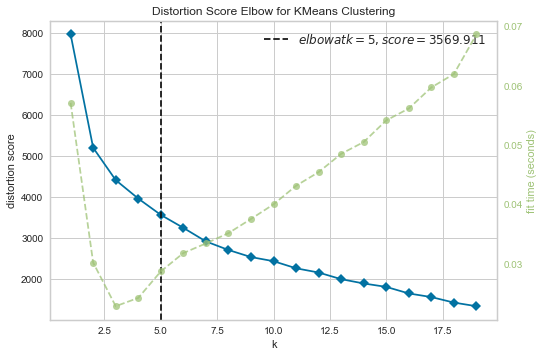

In [513]:
#!pip3 install yellowbrick #uncomment if you have not installed yellowbric
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k = (1,20))
visualizer.fit(grouped_clusters)
visualizer.show()

**Based on the elbow method above, we should use 5 clusters**

In [514]:
from sklearn.preprocessing import StandardScaler
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, init='random', n_init=500).fit(grouped_clusters)
labels = kmeans.labels_
labels
kmeans.cluster_centers_

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.11111111e-01,  2.08166817e-17,  2.22222222e-01, ...,
         5.55555556e-02,  1.11111111e-01,  2.08166817e-17],
       [ 0.00000000e+00,  6.93889390e-18,  0.00000000e+00, ...,
         1.38777878e-17,  3.33333333e-01,  6.93889390e-18],
       [ 1.66666667e-01,  1.66666667e-01,  2.77555756e-17, ...,
         2.50000000e-01,  3.33333333e-01,  8.33333333e-02],
       [-2.77555756e-17,  6.93889390e-18,  1.53846154e-01, ...,
         1.38777878e-17,  2.77555756e-17,  6.93889390e-18]])

In [515]:
labels

array([1, 4, 4, 1, 4, 4, 3, 1, 4, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1,
       1, 1, 2, 4, 0, 1, 1, 4, 3, 1, 1, 4, 2, 4, 4, 4, 1, 2, 3, 3, 1, 4,
       1, 4, 1], dtype=int32)

In [516]:
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass
    
covid_merged = covid_df
covid_merged = covid_merged.join(neighborhoods_venues_sorted.set_index('zipcode'), on='zipcode')

covid_merged = covid_merged.dropna() 
covid_merged['Cluster Labels'] = covid_merged['Cluster Labels'].astype(int)
covid_merged.head()

,zipcode,related city,cases,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,32703,Apopka,150,28.6635,-81.4744,0,Pizza Place,Grocery Store,Discount Store,Convenience Store,American Restaurant,Fast Food Restaurant,Clothing Store,Mexican Restaurant,Gas Station,Sports Bar
1,32709,Christmas,7,28.5381,-81.0092,4,Convenience Store,Campground,Grocery Store,Monument / Landmark,Sculpture Garden,Gas Station,Farm,Event Space,Exhibit,Fabric Shop
2,32712,Apopka,148,28.7264,-81.5219,4,Baseball Field,Pizza Place,Golf Course,American Restaurant,Park,Discount Store,Furniture / Home Store,Martial Arts Dojo,Steakhouse,Mexican Restaurant
3,32751,Maitland,35,28.6282,-81.3546,0,Pizza Place,Convenience Store,Park,Grocery Store,Pharmacy,Italian Restaurant,Ice Cream Shop,Sandwich Place,Steakhouse,Chinese Restaurant
4,32757,Mount Dora,0,28.7520,-81.6364,4,Airport,Lake,Post Office,Italian Restaurant,Farm,Park,Bed & Breakfast,Zoo,Farmers Market,Event Space


**Its starting to look like we have two major clusters**

**Now I visualize the clusters**

In [517]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors



orange_map = folium.Map(location=[28.4845, -81.2519], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(covid_merged['Latitude'], covid_merged['Longitude'], covid_merged['zipcode'], covid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(orange_map)
       
orange_map

**As we can see almost all of our zipcodes have been clustered into one giant cluster. However, I will proceed to examine what the clusters have in common**

In [518]:
covid_merged.loc[covid_merged['Cluster Labels'] == 0, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,32703,0,Pizza Place,Grocery Store,Discount Store,Convenience Store,American Restaurant,Fast Food Restaurant,Clothing Store,Mexican Restaurant,Gas Station,Sports Bar
3,32751,0,Pizza Place,Convenience Store,Park,Grocery Store,Pharmacy,Italian Restaurant,Ice Cream Shop,Sandwich Place,Steakhouse,Chinese Restaurant
7,32792,0,Pharmacy,Gym,Grocery Store,Video Store,Sandwich Place,Restaurant,Pizza Place,Gym / Fitness Center,Donut Shop,Discount Store
14,32807,0,Convenience Store,Grocery Store,Cuban Restaurant,Discount Store,Pizza Place,Sandwich Place,Donut Shop,Rental Car Location,Mexican Restaurant,Pharmacy
15,32808,0,Fast Food Restaurant,Convenience Store,Pharmacy,Disc Golf,Intersection,Discount Store,Grocery Store,Park,Sandwich Place,Chinese Restaurant


In [519]:
cluster_0=covid_merged.loc[covid_merged['Cluster Labels'] == 0, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_0=cluster_0.drop(columns=['zipcode', 'Cluster Labels'])
cluster_0 = cluster_0.stack().value_counts()
cluster_0 = cluster_0.head(5)
cluster_0

Pizza Place             15
Convenience Store       14
Grocery Store           13
Fast Food Restaurant    12
Pharmacy                11
dtype: int64

In [520]:
covid_merged.loc[covid_merged['Cluster Labels'] == 1, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,32819,1,Theme Park Ride / Attraction,Bar,Gift Shop,Coffee Shop,Theme Park,American Restaurant,Mexican Restaurant,English Restaurant,Breakfast Spot,Souvenir Shop
34,32830,1,Theme Park Ride / Attraction,Resort,Gift Shop,Lounge,American Restaurant,Hotel,Hotel Bar,Train Station,Buffet,Golf Course
39,32836,1,Theme Park Ride / Attraction,Gift Shop,American Restaurant,Sandwich Place,Ice Cream Shop,Park,Public Bathroom,Breakfast Spot,Fast Food Restaurant,Resort


In [521]:
cluster_1=covid_merged.loc[covid_merged['Cluster Labels'] == 1, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_1=cluster_1.drop(columns=['zipcode', 'Cluster Labels'])
cluster_1 = cluster_1.stack().value_counts()
cluster_1 = cluster_1.head(5)
cluster_1

Theme Park Ride / Attraction    3
Gift Shop                       3
American Restaurant             3
Breakfast Spot                  2
Resort                          2
dtype: int64

In [522]:
covid_merged.loc[covid_merged['Cluster Labels'] == 2, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,32821,2,Hotel,Theme Park Ride / Attraction,Aquarium,American Restaurant,Pharmacy,Theme Park,Italian Restaurant,Stadium,Steakhouse,Seafood Restaurant


In [523]:
cluster_2=covid_merged.loc[covid_merged['Cluster Labels'] == 2, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_2=cluster_2.drop(columns=['zipcode', 'Cluster Labels'])
cluster_2 = cluster_2.stack().value_counts()
cluster_2 = cluster_2.head(5)
cluster_2

Theme Park Ride / Attraction    1
Hotel                           1
Steakhouse                      1
Seafood Restaurant              1
Stadium                         1
dtype: int64

In [524]:
covid_merged.loc[covid_merged['Cluster Labels'] == 3, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,32789,3,Grocery Store,Italian Restaurant,American Restaurant,Pet Store,Mexican Restaurant,Pharmacy,Pizza Place,Steakhouse,Sandwich Place,Café
9,32801,3,Bar,Coffee Shop,American Restaurant,Park,Vietnamese Restaurant,Pizza Place,Cocktail Bar,Hotel,Basketball Stadium,Burger Joint
10,32803,3,Vietnamese Restaurant,Coffee Shop,Park,Asian Restaurant,Mexican Restaurant,Brewery,Pizza Place,Grocery Store,American Restaurant,Beer Bar
11,32804,3,Bar,Coffee Shop,American Restaurant,Grocery Store,Pet Store,Park,Brewery,Theater,Wine Bar,Italian Restaurant
12,32805,3,Bar,Hotel,American Restaurant,Gay Bar,Coffee Shop,Fried Chicken Joint,Cocktail Bar,French Restaurant,Spa,Bed & Breakfast


In [525]:
cluster_3=covid_merged.loc[covid_merged['Cluster Labels'] == 3, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_3=cluster_3.drop(columns=['zipcode', 'Cluster Labels'])
cluster_3 = cluster_3.stack().value_counts()
cluster_3 = cluster_3.head(5)
cluster_3

American Restaurant    10
Coffee Shop            10
Pizza Place             7
Park                    6
Mexican Restaurant      6
dtype: int64

In [526]:
covid_merged.loc[covid_merged['Cluster Labels'] == 4, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]].head()

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,32709,4,Convenience Store,Campground,Grocery Store,Monument / Landmark,Sculpture Garden,Gas Station,Farm,Event Space,Exhibit,Fabric Shop
2,32712,4,Baseball Field,Pizza Place,Golf Course,American Restaurant,Park,Discount Store,Furniture / Home Store,Martial Arts Dojo,Steakhouse,Mexican Restaurant
4,32757,4,Airport,Lake,Post Office,Italian Restaurant,Farm,Park,Bed & Breakfast,Zoo,Farmers Market,Event Space
5,32776,4,Pool,Pizza Place,Golf Course,Gym / Fitness Center,American Restaurant,Trail,Factory,Electronics Store,English Restaurant,Event Space
8,32798,4,American Restaurant,Golf Course,Airport,Post Office,Soccer Field,Zoo,Farmers Market,Event Space,Exhibit,Fabric Shop


In [527]:
cluster_4=covid_merged.loc[covid_merged['Cluster Labels'] == 4, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]
cluster_4=cluster_4.drop(columns=['zipcode', 'Cluster Labels'])
cluster_4 = cluster_4.stack().value_counts()
cluster_4 = cluster_4.head(5)
cluster_4

Golf Course    7
Event Space    6
Park           5
Farm           5
Pizza Place    4
dtype: int64

**We see from the above analysis that we have 5 distinct clusters**
- **cluster 0 is recreation and farms**
- **cluster 1 is pizza and stores**
- **cluster 2 is coffee and bars**
- **cluster 3 is restaurants**
- **cluster 4 is theme parks**


**Earlier we got some data that included the boundaries of our zipcodes.  We will use it to make our choropleth map of covid-19 cases**

In [528]:
# covid_merged['cases'] = pd.to_numeric(covid_merged['cases'])
covid_df['cases'] = covid_df['cases'].astype(int)


In [529]:
len(data['features'])

47

In [530]:
covid_df.shape

(47, 5)

In [531]:

import folium
folium.Choropleth(geo_data=data,
                      data=covid_df,
                     columns=['zipcode', 'cases'],
                     fill_color='YlOrRd',
                      key_on="feature.properties.ZIP",
                     fill_opacity=0.7,
                     line_opacity=0.2,
                     legend_name='Covid Cases in Orange County by Zipcode').add_to(orange_map)

folium.LayerControl().add_to(orange_map)


In [532]:
markers_colors = []
for lat, lon, poi, cluster in zip(covid_merged['Latitude'], covid_merged['Longitude'], covid_merged['zipcode'], covid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(orange_map)
       
orange_map


**Doing a visual analysis of the clustered neighborhoods on our choropleth map, we can make a few conclusions. **
- **Almost all of the areas with less than 35 cases are in the orange cluster (recreation and farms)**
    - However, there are a couple of zipcodes in this cluster in higher hit areas
- **The red cluster (pizza and stores) tends to fall within the highest hit areas.  Most zipcodes within this cluster have cases higher than 105.**
- **The blue cluster (theme park and hotels) is a singleton and is between 35 and 70
- **The green cluster (restaurants) almost entirely falls between 35 and 105 cases as well.  However, two of them fall within the 140-175 mark.**
- **Finally the purple cluster (theme parks and gift shops) are a bit all over the place.  Two of them are less than 70 but one is between 140 and 175.  This one is much closer to Orlando which leads me to think that it has other factors affecting it.**

In [533]:
low_covid_high_cluster = covid_merged[covid_merged['cases'] < 35]
low_covid_high_cluster = low_covid_high_cluster[low_covid_high_cluster['Cluster Labels'] == 1]
low_covid_high_cluster

,zipcode,related city,cases,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,32830,Orlando,0,28.4209,-81.581,1,Theme Park Ride / Attraction,Resort,Gift Shop,Lounge,American Restaurant,Hotel,Hotel Bar,Train Station,Buffet,Golf Course
